# Generalized Linear Model : Poisson Regression

Currently, **Concrete** only supports unsigned integers up to 7-bits, for parameters, inputs, and intermediate values such as accumulators. Nevertheless, we want to evaluate a linear regression model with it. Luckily, we can make use of **quantization** to overcome this limitation.

### Let's start by importing some libraries to develop our linear regression model

In [1]:
from copy import deepcopy
import numpy as np

from sklearn.linear_model import PoissonRegressor
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tqdm import tqdm

from concrete.quantization import QuantizedLinear, QuantizedArray, QuantizedModule
from concrete.quantization.quantized_activations import QuantizedActivation

import concrete.numpy as hnp

### And some helpers for visualization

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display

### We need an inputset, get one from OpenML for insurance claims

In [3]:
df = fetch_openml(data_id=41214, as_frame=True, cache=True, data_home="~/.cache/sklearn").frame
df = df.head(50000)

### We want to predict the frequency of insurance claims. Our example will only use a single predictor feature so we can easily visualize results
### First, compute the target value from the input dataset



In [4]:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]

### Let's visualize our inputset to get a grasp of it. The target variable, "Frequency" has a poisson distribution

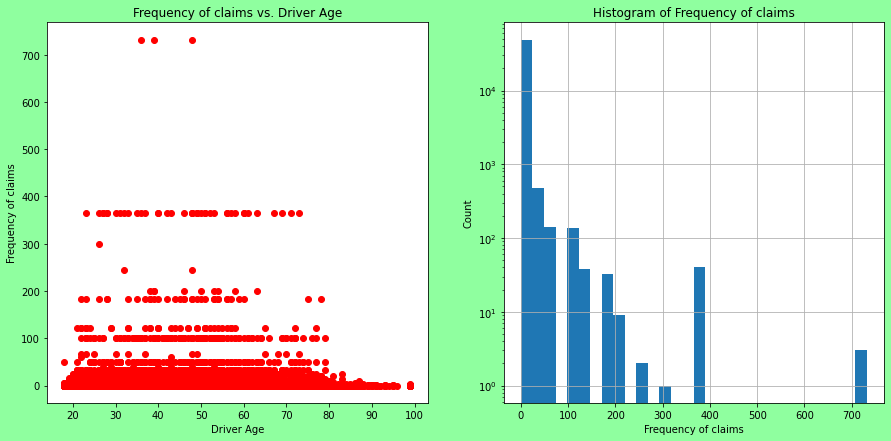

In [5]:
plt.ioff()
fig, ax = plt.subplots(1,2,figsize=(15,7))
fig.patch.set_facecolor('xkcd:mint green')
ax[0].set_title("Frequency of claims vs. Driver Age")
ax[0].set_xlabel("Driver Age")
ax[0].set_ylabel("Frequency of claims")
ax[0].scatter(df["DrivAge"], df["Frequency"], marker="o", color="red")
ax[1].set_title("Histogram of Frequency of claims")
ax[1].set_xlabel("Frequency of claims")
ax[1].set_ylabel("Count")
df["Frequency"].hist(bins=30, log=True, ax=ax[1])
display(fig)

### Now, we need a model so let's define it

### Let's split the data, keeping a part of the data to be used for calibration. The calibration set is not used in training nor for testing the model.

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)
df_calib, df_test = train_test_split(df_test, test_size=100, random_state=0)


### Train the scikit-learn PoissonRegressor model 

In [7]:
reg = PoissonRegressor(alpha=1e-12, max_iter=300)
reg.fit(df_train["DrivAge"].values.reshape(-1,1), df_train["Frequency"])

PoissonRegressor(alpha=1e-12, max_iter=300)

### Time to make some predictions

In [8]:
test_data = np.sort(df_test["DrivAge"].values).reshape(-1,1)
predictions = reg.predict(test_data)

### Let's visualize our predictions to see how our model performs. Note that the graph is on a Y log scale so the regression line looks linear.

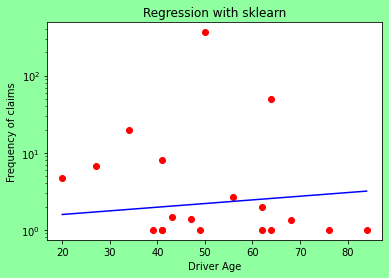

In [9]:
plt.clf()
fig, ax = plt.subplots(1)
fig.patch.set_facecolor('xkcd:mint green')
ax.set_yscale("log")
ax.plot(test_data, predictions, color="blue")
ax.scatter(df_test["DrivAge"], df_test["Frequency"], marker="o", color="red")
ax.set_xlabel("Driver Age")
ax.set_title("Regression with sklearn")
ax.set_ylabel("Frequency of claims")
display(fig)

### FHE models need to be quantized, so let's define a **Quantized Poisson Regressor** (Generalized Linear Model with exponential link)

We use the quantization primitives available in the Concrete library: QuantizedArray, QuantizedFunction, and QuantizedLinear

In [10]:
class QuantizedExp(QuantizedActivation):
    """Quantized exponential function."""

    def calibrate(self, x: np.ndarray):
        self.q_out = QuantizedArray(self.n_bits, np.exp(x))

    def __call__(self, q_input: QuantizedArray) -> QuantizedArray:
        quant_exp = np.exp(self.dequant_input(q_input))
        q_out = self.quant_output(quant_exp)
        return q_out
        
class QuantizedGLM(QuantizedModule):
    def __init__(self, n_bits, sklearn_model, calibration_data) -> None:
        # Create a QuantizedLinear layer
        self.n_bits = n_bits

        self.q_calibration_data = QuantizedArray(n_bits, calibration_data)

        q_weights = QuantizedArray(1, np.expand_dims(sklearn_model.coef_,1))
        q_bias = QuantizedArray(1, sklearn_model.intercept_)
        q_layer = QuantizedLinear(6, q_weights, q_bias)
        quant_layers_dict = {}
        # Calibrate and get new calibration_data for next layer/activation
        calibration_data = self._calibrate_and_store_layers_activation(
            "linear", q_layer, calibration_data, quant_layers_dict
        )

        # Create a new quantized layer (based on type(layer))
        q_exp = QuantizedExp(n_bits=7)
        calibration_data = self._calibrate_and_store_layers_activation(
            "invlink", q_exp, calibration_data, quant_layers_dict
        )

        super().__init__(quant_layers_dict)


    def _calibrate_and_store_layers_activation(self, name, q_function, calibration_data, quant_layers_dict):
        # Calibrate the output of the layer
        q_function.calibrate(calibration_data)
        # Store the learned quantized layer
        quant_layers_dict[name] = q_function
        # Create new calibration data (output of the previous layer)
        q_calibration_data = QuantizedArray(self.n_bits, calibration_data)
        # Dequantize to have the value in clear and ready for next calibration
        return q_function(q_calibration_data).dequant()


    def quantize_input(self, x):
        q_input_arr = deepcopy(self.q_calibration_data)
        q_input_arr.update_values(x)
        return q_input_arr

### Let's quantize our model parameters

First, we get the calibration data, and we then run it through the non quantized model to determine all possible intermediate values. After each operation these values are quantized and the quantized version of the operations are stored in the QuantizedGLM module.

In [11]:
calib_data = np.expand_dims(df_calib["DrivAge"].values, 1)
n_bits = 5
q_glm = QuantizedGLM(n_bits, reg, calib_data)

### And quantize our inputs and perform quantized inference. 

In [12]:
q_test_data = q_glm.quantize_input(test_data)
y_pred = q_glm.forward_and_dequant(q_test_data)


### Visualize the results

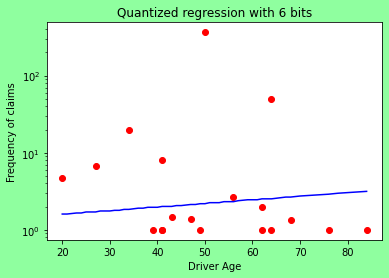

In [13]:
plt.clf()
fig, ax = plt.subplots(1)
fig.patch.set_facecolor('xkcd:mint green')
ax.set_yscale("log")
ax.plot(test_data, y_pred, color="blue")
ax.scatter(df_test["DrivAge"], df_test["Frequency"], marker="o", color="red")
ax.set_xlabel("Driver Age")
ax.set_ylabel("Frequency of claims")
ax.set_title("Quantized regression with {} bits".format(6))
display(fig)

### Now it's time to make the inference homomorphic.

In [14]:

BENCHMARK_CONFIGURATION = hnp.CompilationConfiguration(
    dump_artifacts_on_unexpected_failures=True,
    enable_topological_optimizations=True,
    check_every_input_in_inputset=True,
    treat_warnings_as_errors=True,
)

engine = q_glm.compile(
    q_test_data,
    BENCHMARK_CONFIGURATION,
    show_mlir=False,
)


### Let's compile our quantized inference function to it's homomorphic equivalent.

In [15]:
from PIL import Image
file = Image.open(engine.draw())
file.show()
file.close()

### Finally, let's do homomorphic inference.

In [16]:
y_pred_fhe = np.zeros((test_data.shape[0],), np.float32)
for i, test_sample in enumerate(tqdm(q_test_data.qvalues)):
    q_sample = np.expand_dims(test_sample, 1).transpose([1,0]).astype(np.uint8)
    q_pred_fhe = engine.run(q_sample)
    y_pred_fhe[i] = q_glm.dequantize_output(q_pred_fhe)

100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


### And visualize it

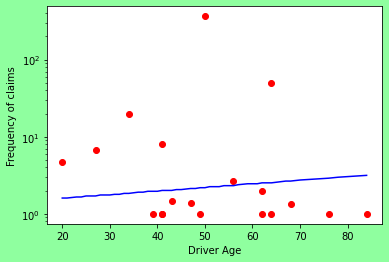

In [17]:
plt.clf()
fig, ax = plt.subplots(1)
fig.patch.set_facecolor('xkcd:mint green')
ax.set_yscale("log")
ax.plot(test_data, y_pred_fhe, color="blue")
ax.scatter(df_test["DrivAge"], df_test["Frequency"], marker="o", color="red")
ax.set_xlabel("Driver Age")
ax.set_ylabel("Frequency of claims")
display(fig)

### Enjoy!